# Detecting Insults in Social Commentary

### Problem Definition:

The challenge is to detect if a comment from an online conversation can be considered insulting to another participant in the conversation. The idea is to create a generalizable single-class classifier which could operate in a near real-time mode. In this project I build a system that can detect whether or not any given comment is insulting by building a machine learning system.

In addition to just building a classifier this project also test different classifier - **Linear & Non-Linear** and decide which might be the best classifier for the purpose.


Ref: https://www.kaggle.com/c/detecting-insults-in-social-commentary

Ref: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


In [4]:
import numpy as np
import pandas as pd
import sklearn
# to split data
from sklearn.cross_validation import train_test_split, ShuffleSplit
import sklearn.feature_extraction.text as text

In [5]:
# Support Vector machine
from sklearn import svm
# Naive Bayes
import sklearn.naive_bayes as nb
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# decision tree
from sklearn.tree import DecisionTreeClassifier
# random forest 
from sklearn.ensemble import RandomForestClassifier

# Methodology

## I. Data Ingestion

Data for training and testing is obtained from Kaggle. The data set contains 3947 examples, each of which consists of the text of a particular post and its desired label. A label of 1 represents an insulting post, while a label of 0 represents a non-insulting post. 

For Example, 

**Text:** “You’re a moron, truth is beyond your reach”, Label: 1

**Text:** “I’ll take that temp…I really hate the heat”, Label: 0


### Loading and preparing the data

In [6]:
# Open the training file with pandas.
df = pd.read_csv("data/train.csv")

In [7]:
# Inspect complete dataset
df.head(5)

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [14]:
# getting the shape of dataframe
df.shape

(3947, 3)

In [18]:
# Getting the Count of Positive and Negative
df[['Comment','Insult']].groupby('Insult').count()

,Comment
Insult,
0,2898
1,1049


In total, **1049** of the examples are labelled as **“insulting”**, while the remaining **2898** examples are labelled as **“not insulting”**.

In [9]:
# Inspect data
df[['Insult', 'Comment']].tail(5)

,Insult,Comment
3942,1,"""you are both morons and that is never happening"""
3943,0,"""Many toolbars include spell check, like Yahoo..."
3944,0,"""@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F..."
3945,0,"""How about Felix? He is sure turning into one ..."
3946,0,"""You're all upset, defending this hipster band..."


## II. Data Wrangling

Once the data has been loaded, data wrangling pipeline is being created to clean data and remove garbage characters. 

1. Text Cleansing.
2. Tokenization
3. Stemming
4. Lemmatization
5. Stop words removal
6. Rare words removal

In [20]:
# splitting Labels and comments
label, comments = df['Insult'],df['Comment']

In [21]:
# checking label, comments
type(label), type(comments)

(pandas.core.series.Series, pandas.core.series.Series)

####  Text Cleaning: To Lower Case

In [22]:
# converting data to lowercase
comments=comments.str.lower()

In [23]:
comments.iloc[5]

'"@sdl ok, but i would hope they\'d sign him to a one-year contract to start with. give him the chance to be reliable and productive, but give themselves the out if all his time off has hurt his playing skills or if he falls back into old habits."'

In [24]:
from nltk import sent_tokenize
import re
from re import sub
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

#### Text Cleaning: Removing special characters

In [25]:
def remove_special_char(x):
    # this will replace all punctuations with spaces
    punc = string.punctuation.replace("-", "")
    punc = punc.replace("'", "")
    pat= r"[{}]".format(punc)
    x=re.sub(pat, " ", x)
    
    # this will replace all digits with None
    x=re.sub(pattern=r"\d", repl=r" ", string=x)
    
    # this will strip extra white spaces
    return " ".join( i for i in stemming(x))

#### Stemming and Lemmatization

In [26]:
def stemming(x):
    #st = LancasterStemmer()
    st = WordNetLemmatizer()
    words=x.strip().split()
    st3=SnowballStemmer("english")
    return [st3.stem(st.lemmatize(x)) for x in words]

In [27]:
#making a copy of transformed 
comments_tran = comments.apply(remove_special_char)

In [28]:
# checking the change
comments.iloc[1], comments_tran.iloc[1]

('"i really don\'t understand your point.\\xa0 it seems that you are mixing apples and oranges."',
 "i realli don't understand your point \\xa it seem that you are mix appl and orang")

#### Removing Stopwords

In [29]:
import nltk
from nltk.corpus import stopwords
# getting stopwords for classifier
stopWords = set(stopwords.words('english'))
type(stopWords), len(stopWords)

(set, 153)

#### Tokenization

In [30]:
tf = text.TfidfVectorizer(stop_words=stopWords, ngram_range=(1, 1))
X = tf.fit_transform(comments_tran)
print(X.shape)

(3947, 11775)


In [19]:
# this is experimental tokenizer with ngram features
# tf = text.TfidfVectorizer(stop_words=stopWords,ngram_range=(1, 5))

In [31]:
# checking the sparsity of matrix
print("Each sample has ~{0:.2%} non-zero features.".format(X.nnz / float(X.shape[0] * X.shape[1])))

Each sample has ~0.13% non-zero features.


In [32]:
# Storing words in vocab list
vocab=list((tf.vocabulary_).keys())
len(vocab)

11775

In [33]:
vocab.sort()
print(vocab[:50])

['aaaaaaaaa', 'aaaah', 'aaahhh', 'aac', 'aamir', 'aap', 'aarongmy', 'ab', 'abacha', 'abandon', 'abc', 'abe', 'abel', 'aberdeen', 'abet', 'abid', 'abigail', 'abil', 'ability', 'abit', 'abl', 'abnorm', 'abolish', 'abolit', 'abomin', 'abort', 'abortifaci', 'abortion', 'abov', 'abraham', 'abroad', 'abrupt', 'abscam', 'absenc', 'absolut', 'absolutejok', 'absolutely', 'abstain', 'abstractfirework', 'absurd', 'absurdum', 'absurt', 'aburrido', 'abus', 'abuse', 'abuses', 'abxxv', 'abysm', 'ac', 'academ']


# III. Building Model

I started out by trying linear classification models **Naïve Bayes, SVMs, and Logistic Regression** for building the classifier as they are very common and easy models for classification. 

Following this I built Non-Linear classifiers  like **Random Forest Classifier, Decision Tree Classifier**. Evnetually, I compare how these classifiers perform. 

I have implemented each of these classifiers with only unigrams features, followed by basic preprocessing (such as lowercasing all letters, removing punctuation and stemming).

#### Preparing Data - Train and Validation

In [34]:
(X_train, X_val,label_train, label_val) = cv.train_test_split(X, label, test_size=.2)

In [35]:
# investigating the shape of data
X_train.shape, X_val.shape

((3157, 11775), (790, 11775))

## Linear Classification Models

### 1. Logistic Regression (LR)

ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [36]:
def model_LR():
    # creating classifier
    clf = LogisticRegression(tol=1e-8, penalty='l2', C=2)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p)

### 2. Support Vector Machine (SVM)

ref: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [142]:
def model_SVM():
    # creating classifier
    clf = svm.LinearSVC(penalty='l2', loss='squared_hinge',tol=1e-8)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    return clf.predict(X_val)

### 3. Naive Bayes (NB)

ref: http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

In [38]:
# Bernoulli Naive Baiyes
def model_BernoulliNB():
    # creating classifier
    clf = nb.BernoulliNB(alpha=1.0, binarize=0.0)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p)

## Non-Linear Classification Models


### 1. Random Forest Classifier

In [39]:
# Random Forest Classifier
def model_RF():
    # creating classifier
    clf = RandomForestClassifier(n_estimators=100)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p)

### 2. Decision Tree Classifier (DT)

In [41]:
def model_DT():
    # creating classifier
    clf = DecisionTreeClassifier(max_depth=100)
    # training classifier
    clf.fit(X_train, label_train)
    # model type
    print("Model: ",type(clf))
    # Predicting probabilities
    p = clf.predict_proba(X_val)
    return (clf.predict(X_val),p)

# IV. Model Evaluation

The primary evaluation metrics that I have used on my system training are **accuracy and 10-fold cross validation**. I used the training accuracy to determine how well the model is fitting in training data and testing with validation data. The cross validation accuracy was more significant because it was more generalized.

In [42]:
# ROC and AUC score
from sklearn.metrics import roc_auc_score as auc_score
# Confusion Matrix
from sklearn.metrics import confusion_matrix

In [66]:
def model_evaluation(model,label_test):
    #accuracy=np.mean(model == label_test)
    #print("%.4f"%np.mean(model == label_test))
    # confusion matrix:
    cm = confusion_matrix(label_test, model, labels=None, sample_weight=None)
    tp, fn, fp, tn = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    precision= float(tp)/(tp+fp)
    recall =  float(tp)/(tp+tn)
    accuracy = np.mean(model == label_test)
    print_results (precision, recall, accuracy)
    return accuracy
    

def print_results (precision, recall, accuracy):
    banner = "Here is the classification report"
    print ('\n',banner)
    print ('=' * len(banner))
    print ('{0:10s} {1:.1f}'.format('Precision',precision*100))
    print ('{0:10s} {1:.1f}'.format('Recall',recall*100))
    print ('{0:10s} {1:.1f}'.format('Accuracy',accuracy*100))
    
    
    #print("*****PRECISION****")
    #print("%.4f"%(tp/(tp+fp)))
    #print("*****RECALL****")
    #print("%.4f"%(tp/(tp+tn)))
    #return accuracy

## Model Accuracy, Precision, Recall

#### Logistic Regression

In [143]:
# model prediction
clf_LR, p = model_LR()
# model evaluation
acc_LR = model_evaluation(clf_LR, label_val)

print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))

Model:  <class 'sklearn.linear_model.logistic.LogisticRegression'>

 Here is the classification report
Precision  73.4
Recall     98.1
Accuracy   71.9
AUC Score  52.1


#### Support Vector Machine

In [144]:
# model prediction
clf_SVM = model_SVM()
# model evaluation
acc_SVM = model_evaluation(clf_SVM, label_val)

Model:  <class 'sklearn.svm.classes.LinearSVC'>

 Here is the classification report
Precision  73.0
Recall     91.9
Accuracy   64.2


#### Naive Bayes

In [72]:
# model prediction
clf_NB,p=model_BernoulliNB()
# model evaluation
acc_NB = model_evaluation(clf_NB, label_val)

print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))

Model:  <class 'sklearn.naive_bayes.BernoulliNB'>

 Here is the classification report
Precision  72.0
Recall     98.7
Accuracy   67.8
AUC Score  41.3


#### Random Forest

In [70]:
# model prediction
clf_RF,p=model_RF()
# model evaluation
acc_RF = model_evaluation(clf_RF, label_val)

print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))

Model:  <class 'sklearn.ensemble.forest.RandomForestClassifier'>

 Here is the classification report
Precision  73.6
Recall     90.5
Accuracy   64.2
AUC Score  46.6


#### Decision Tree

In [71]:
# model prediction
clf_DT,p=model_DT()
# model evaluation
acc_DT = model_evaluation(clf_DT, label_val)

print ('{0:10s} {1:.1f}'.format('AUC Score',auc_score(label_val, p[:,1])*100))

Model:  <class 'sklearn.tree.tree.DecisionTreeClassifier'>

 Here is the classification report
Precision  73.5
Recall     94.4
Accuracy   68.1
AUC Score  51.4


In [137]:
# Accuracy for all Models
accuracy_normal=[acc_LR, acc_SVM, acc_NB, acc_RF, acc_DT]
accuracy_normal=[('{0:2f}'.format(i*100)) for i in accuracy_normal]

In [138]:
accuracy_normal

['71.139241', '63.544304', '67.848101', '64.177215', '68.101266']

## Accuracy : 10-Fold Cross Validation

In [52]:
# Logistic Regression
clf1 = LogisticRegression(tol=1e-8, penalty='l2', C=2)
# Support Vector Machines
clf2 = svm.LinearSVC(penalty='l2', loss='squared_hinge')
# Naive Bayes
clf3 = nb.BernoulliNB(alpha=1.0, binarize=0.0)
# Random Forest
clf4 = RandomForestClassifier(n_estimators=100)
# Decision Tree
clf5 = DecisionTreeClassifier(max_depth=100)

models=[clf1, clf2, clf3, clf4, clf5]

In [90]:
n_Folds = 10
# Accuracy after cross validation:
accuracy_cv=[]
for clf in models:
    accuracy_common=0
    for test_run in range(n_Folds):
        (X_train, X_test, y_train, y_test) = cv.train_test_split(X, label, test_size=.2)
        # call classifier
        clf.fit(X_train, y_train)
        model=clf.predict(X_test)
        # compare result
        accuracy=np.mean(model == y_test)
        # append to common
        accuracy_common += accuracy
        # final score
    print ('{0:10s} {1:.1f}'.format('Accuracy',float(accuracy_common)/10*100))
    accuracy_cv.append('{0:.1f}'.format(float(accuracy_common)/10*100))
    
print("Normal Accuracy")
print("================")
print(accuracy_normal)
print("Accuracy post CV")
print("================")
print(accuracy_cv)

Accuracy   82.1
Accuracy   81.9
Accuracy   74.6
Accuracy   81.7
Accuracy   78.3
Normal Accuracy
['71.139241', '63.544304', '67.848101', '64.177215', '68.101266', '68.101266']
Accuracy post CV
['82.1', '81.9', '74.6', '81.7', '78.3']


# V. Results

With all of the above features and techniques implemented, a cross-validation accuracy of 82.8% was achieved for **Support Vector Machine** Classifier. This was followed by **Random Forest Classifier and Logistic Regression** Respectively.

Following diagram visually represent the results gained after Cross Validation.

In [128]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline

# set plot size
fig_size=[0,0]
fig_size[0] = 7
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

# setting style
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

### Model Evaluation: Basic Accuracy

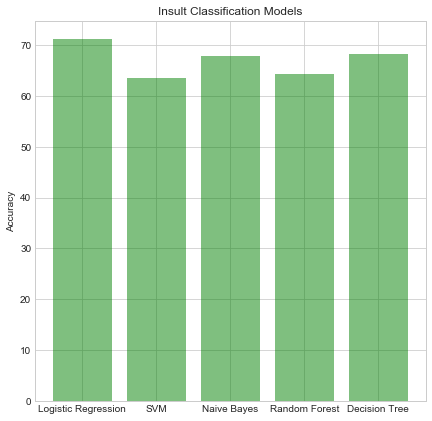

In [139]:
linear_models = ('Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(linear_models)) 
plt.bar(y_pos, accuracy_normal, align='center', alpha=0.5, color='green')
plt.xticks(y_pos, linear_models)
plt.ylabel('Accuracy')
plt.title('Insult Classification Models')

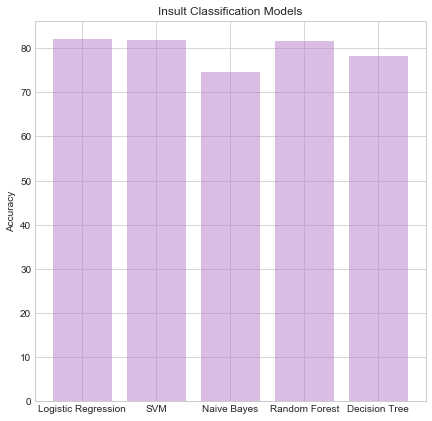

In [141]:
linear_models = ('Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest', 'Decision Tree')
y_pos = np.arange(len(linear_models)) 
plt.bar(y_pos, accuracy_cv, align='center', alpha=0.5, color='m')
plt.xticks(y_pos, linear_models)
plt.ylabel('Accuracy')
plt.title('Insult Classification Models')